In [1]:
# Importing all necessary libraries here

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_curve, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler

c:\Users\carso\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [13]:
#reading in the data; adjust as needed

df = pd.read_csv('data/startup data.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [14]:
# This stndardizes all non 0/1 columns in the dataset

numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
non_binary_columns = [col for col in numerical_columns if df[col].nunique() > 2]
scaler = StandardScaler()
df[non_binary_columns] = scaler.fit_transform(df[non_binary_columns])
print(df[non_binary_columns].head)

<bound method NDFrame.head of      Unnamed: 0  latitude  longitude  age_first_funding_year  \
0      1.297828  1.027268   1.451271                0.005448   
1     -1.104657 -0.341900  -0.823630                1.151960   
2      1.285831 -1.501922  -0.610018               -0.479349   
3      0.497000 -0.320134  -0.827040                0.357050   
4      1.288830 -0.197397  -0.843535               -0.891013   
..          ...       ...        ...                     ...   
918   -0.660752 -0.207743  -0.841624               -0.684643   
919    0.446011  1.066294   1.445070                1.999320   
920   -0.045884 -0.296615  -0.825515                2.495038   
921    0.050095 -0.256911  -0.837688               -0.588552   
922   -0.330823 -0.302359  -0.823297                0.352666   

     age_last_funding_year  age_first_milestone_year  age_last_milestone_year  \
0                -0.313102                  0.542211                 0.607372   
1                 2.044918             

In [15]:
# encoding the dependent variable

df['status'] = df.status.map({'acquired':1, 'closed':0})
df['status'].astype(int)

0      1
1      1
2      1
3      1
4      0
      ..
918    1
919    0
920    0
921    1
922    1
Name: status, Length: 923, dtype: int32

In [16]:
#checking for missing values

null=pd.DataFrame(df.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(df.isna().sum()/len(df)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1)

,Null Values,% Missing Values
Unnamed: 6,493,53.412784
closed_at,588,63.705309
age_first_milestone_year,152,16.468039
age_last_milestone_year,152,16.468039
state_code.1,1,0.108342


In [17]:
# filling in some missing values

df['age_first_milestone_year'] = df['age_first_milestone_year'].fillna(value="0")
df['age_last_milestone_year'] = df['age_last_milestone_year'].fillna(value="0")

In [30]:
# checking for duplicate rows

duplicate = df[df.duplicated()] 
print("Duplicate Rows :")

Duplicate Rows :


In [19]:
# engineering some additional features taken from the notebook in the repository

df['has_RoundABCD'] = np.where((df['has_roundA'] == 1) | (df['has_roundB'] == 1) | (df['has_roundC'] == 1) | (df['has_roundD'] == 1), 1, 0)
df['has_Investor'] = np.where((df['has_VC'] == 1) | (df['has_angel'] == 1), 1, 0)
df['has_Seed'] = np.where((df['has_RoundABCD'] == 0) & (df['has_Investor'] == 1), 1, 0)
df['invalid_startup'] = np.where((df['has_RoundABCD'] == 0) & (df['has_VC'] == 0) & (df['has_angel'] == 0), 1, 0)

In [20]:
print(df.columns)

Index(['Unnamed: 0', 'state_code', 'latitude', 'longitude', 'zip_code', 'id',
       'city', 'Unnamed: 6', 'name', 'labels', 'founded_at', 'closed_at',
       'first_funding_at', 'last_funding_at', 'age_first_funding_year',
       'age_last_funding_year', 'age_first_milestone_year',
       'age_last_milestone_year', 'relationships', 'funding_rounds',
       'funding_total_usd', 'milestones', 'state_code.1', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
       'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA',
       'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants',
       'is_top500', 'status', 'has_RoundABCD', 'has_Investor', 'has_Seed',
       'invalid_startup'],
      dtype='object')


In [21]:
# dropping all features not used in the analysis

df = df.drop(['state_code'],axis=1)
df = df.drop(['id'],axis=1)
df = df.drop(['Unnamed: 6'],axis=1)
df = df.drop(['category_code'],axis=1)
df = df.drop(['object_id'],axis=1)
df = df.drop(['zip_code'],axis=1)
df = df.drop(['founded_at'],axis=1)
df = df.drop(['closed_at'],axis=1)
df = df.drop(['first_funding_at'],axis=1)
df = df.drop(['last_funding_at'],axis=1)
df = df.drop(['city'],axis=1)
df = df.drop(['name'],axis=1)
df = df.drop(['Unnamed: 0'],axis=1)
df = df.drop(['latitude','longitude'],axis=1)
df = df.drop(['state_code.1'],axis=1)
df = df.drop(['is_otherstate'],axis=1)
df = df.drop(['is_othercategory'],axis=1)
df = df.drop(['labels'],axis=1)

In [22]:
print(df.columns)

Index(['age_first_funding_year', 'age_last_funding_year',
       'age_first_milestone_year', 'age_last_milestone_year', 'relationships',
       'funding_rounds', 'funding_total_usd', 'milestones', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_software', 'is_web', 'is_mobile', 'is_enterprise',
       'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech',
       'is_consulting', 'has_VC', 'has_angel', 'has_roundA', 'has_roundB',
       'has_roundC', 'has_roundD', 'avg_participants', 'is_top500', 'status',
       'has_RoundABCD', 'has_Investor', 'has_Seed', 'invalid_startup'],
      dtype='object')


In [23]:
X = df.drop('status', axis = 1)
y = df['status']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

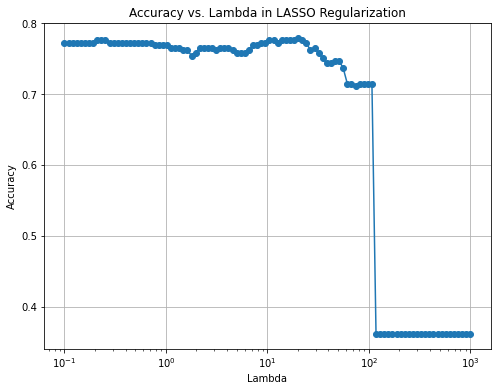

In [32]:
# A plot of how accuracy in the test dataset depends on the regularization strength

C_values = np.logspace(-3, 1, 100)
accuracies = []
for C in C_values:
    lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    lasso_model.fit(X_train, y_train)
    y_pred = lasso_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(1/C_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Lambda in LASSO Regularization')
plt.grid(True)
plt.show()

In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.56      0.64       100
           1       0.78      0.89      0.83       177

    accuracy                           0.77       277
   macro avg       0.76      0.73      0.74       277
weighted avg       0.77      0.77      0.76       277

